<a href="https://colab.research.google.com/github/EnriqueProjectsIA/Mayo-Clinic---STRIP-AI/blob/main/Mayo_clinic_exploration%2BCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import pandas as pd
import numpy as np
import PIL
from PIL import Image
import cv2
import seaborn as sns
from matplotlib import pyplot as plt
import plotly.graph_objects as go
from tqdm import tqdm

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Loading descriptive dataset

* Dataset can be found [here](https://drive.google.com/file/d/1seHMTjCVhHF_bcrCza71NjMt9atE8_UA/view?usp=sharing)

In [3]:
df = pd.read_csv('/content/drive/MyDrive/Data_sets/dfTrain.csv')
df.head()

,Unnamed: 0,image_id,center_id,patient_id,image_num,label,paths,newHeight,newWidth,scaleFactor
0,0,006388_0,11,006388,0,CE,../input/mayo-clinic-strip-ai/train/006388_0.tif,572.0,1024.0,0.016843
1,1,008e5c_0,11,008e5c,0,CE,../input/mayo-clinic-strip-ai/train/008e5c_0.tif,205.0,1024.0,0.034485
2,2,00c058_0,11,00c058,0,LAA,../input/mayo-clinic-strip-ai/train/00c058_0.tif,252.0,1024.0,0.016569
3,3,01adc5_0,11,01adc5,0,LAA,../input/mayo-clinic-strip-ai/train/01adc5_0.tif,1024.0,487.0,0.018341
4,4,026c97_0,4,026c97,0,CE,../input/mayo-clinic-strip-ai/train/026c97_0.tif,1024.0,803.0,0.097218


# Data Visualization

## Class distribution

In [ ]:
classNames = ['CE', 'LAA']
vals = list(df.groupby(['label']).size())

fig = go.Figure(data=[go.Pie(labels=classNames, values=vals, pull=[0, 0.2])])

fig.update_layout(
    title_text="Total number of occurences per class")
fig.show()


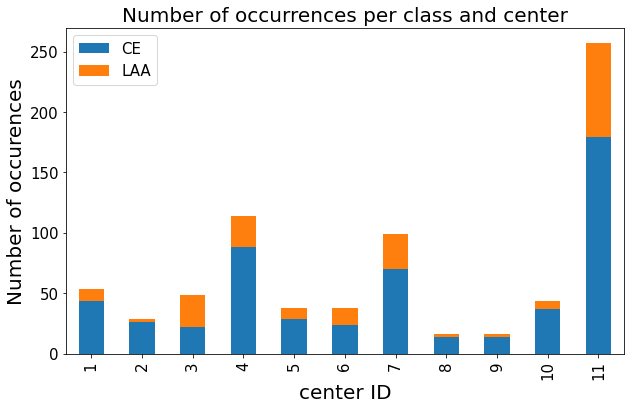

In [ ]:
df_plot = df.groupby(['center_id','label']).size().reset_index().pivot(columns='label', index='center_id', values=0)
df_plot.plot(figsize= (10,6),kind='bar', stacked=True)
plt.title('Number of occurrences per class and center',size = 20)
plt.xlabel('center ID', size = 20)
plt.ylabel('Number of occurences', size = 20)
plt.xticks(size = 15)
plt.yticks(size = 15)
plt.legend(fontsize = 15)
plt.show()

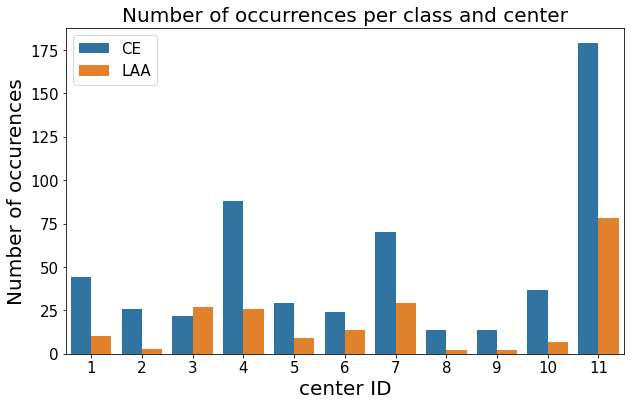

In [ ]:
plt.figure(figsize= (10,6))
sns.countplot(data=df, x='center_id', hue='label')
plt.title('Number of occurrences per class and center',size = 20)
plt.xlabel('center ID', size = 20)
plt.ylabel('Number of occurences', size = 20)
plt.xticks(size = 15)
plt.yticks(size = 15)
plt.legend(fontsize = 15)
plt.show()

* From the plots above one can see that the class LAA is under-represented.
* The dataset is unbalanced

## Image metadata analysis

* The image dataset has a 400 GB size.
* The images can get to sizes up to almost 2 GB which makes it impractical to perform certain analyses.
* In order to ease the process of performing the different tests on the images, the images have been resized by keeping the highest image dimension at 1024 pixels and reducing the lowest size image dimension while keeping the aspect ratio.
* The compression procedure has the advantage to preserve the information of the original size at the scale factor. It also gives us a uniform parameter to compare the image sizes.
* It also has the advantage of producing images of uniform size.

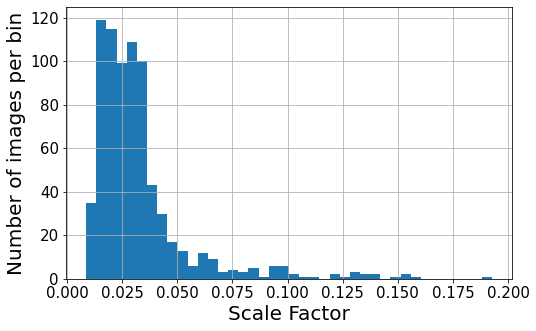

In [ ]:
plt.figure(figsize=(8,5))
df['scaleFactor'].hist(bins = 40)
plt.xlabel('Scale Factor', size =20)
plt.ylabel('Number of images per bin', size = 20)
plt.xticks(size = 15)
plt.yticks(size = 15)
plt.show()

In [ ]:
d1 = df['scaleFactor'].describe()
d2 = pd.Series([df['scaleFactor'].median()], index = ['median'])
d1.append(d2)

count     754.000000
mean        0.032703
std         0.022981
min         0.008672
25%         0.018892
50%         0.027427
75%         0.035677
max         0.192699
median      0.027427
dtype: float64

* Because, the distribution shown in the histogram above is skewed, the median which is more robust against outliers, it is a better value to describe the overall behavior of scale factor.
* Most of the images have been compressed at about 2.7% of its original size.


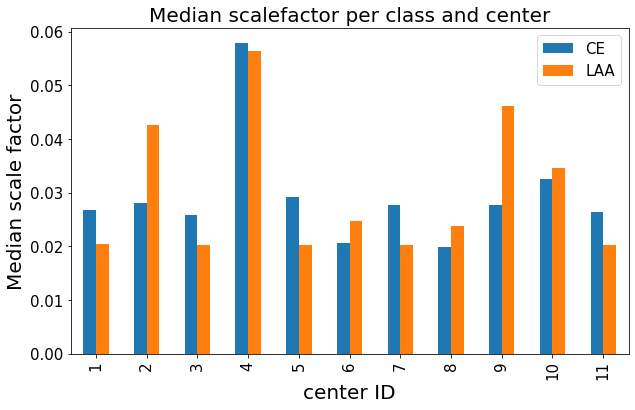

In [ ]:
table = pd.pivot_table(df, values='scaleFactor', index=['center_id'],columns=['label'], aggfunc=np.median)
table.plot(figsize= (10,6),kind='bar')
plt.title('Median scalefactor per class and center',size = 20)
plt.xlabel('center ID', size = 20)
plt.ylabel('Median scale factor', size = 20)
plt.xticks(size = 15)
plt.yticks(size = 15)
plt.legend(fontsize = 15)
plt.show()


* If the images are taken in similar conditions, one would expect to find that the scale factor median has the same value (or very similar) for both classes, as it is the case for center 4.  That would it mean that image sizes does not depend on the class.
* Especially for centers 2 and 9, seems that there is certain bias on how the images are taken as function of the class.
* Centers 5 and 7 seems to have opposite bias than centers 2 and 9.


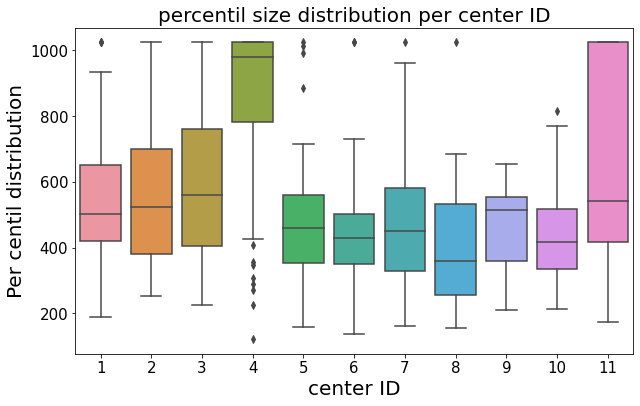

In [ ]:
plt.figure(figsize= (10,6))
sns.boxplot(x='center_id', y='newHeight', data=df)
plt.title('percentil size distribution per center ID',size = 20)
plt.xlabel('center ID', size = 20)
plt.ylabel('Per centil distribution', size = 20)
plt.xticks(size = 15)
plt.yticks(size = 15)
plt.show()

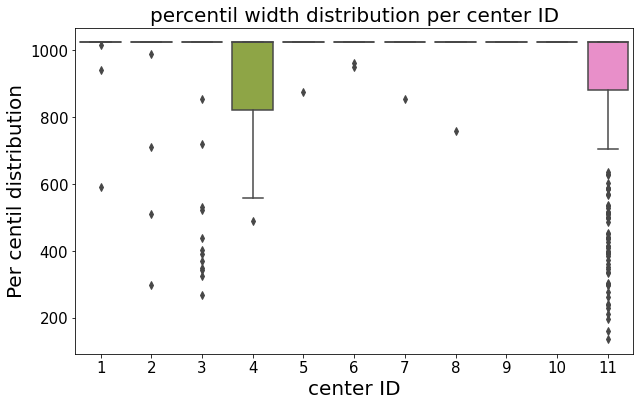

In [ ]:
plt.figure(figsize= (10,6))
sns.boxplot(x='center_id', y='newWidth', data=df)
plt.title('percentil width distribution per center ID',size = 20)
plt.xlabel('center ID', size = 20)
plt.ylabel('Per centil distribution', size = 20)
plt.xticks(size = 15)
plt.yticks(size = 15)
plt.show()

* The two box plots above show that images have not a square shape.
* The image width is typically larger than the height. As consequences some regular strategies for image augmentation as center cropping will not work. 
* Other strategies resize the images to square sizes will distort significally the images characteristics. 


## Image visualization

<Figure size 720x1440 with 0 Axes>

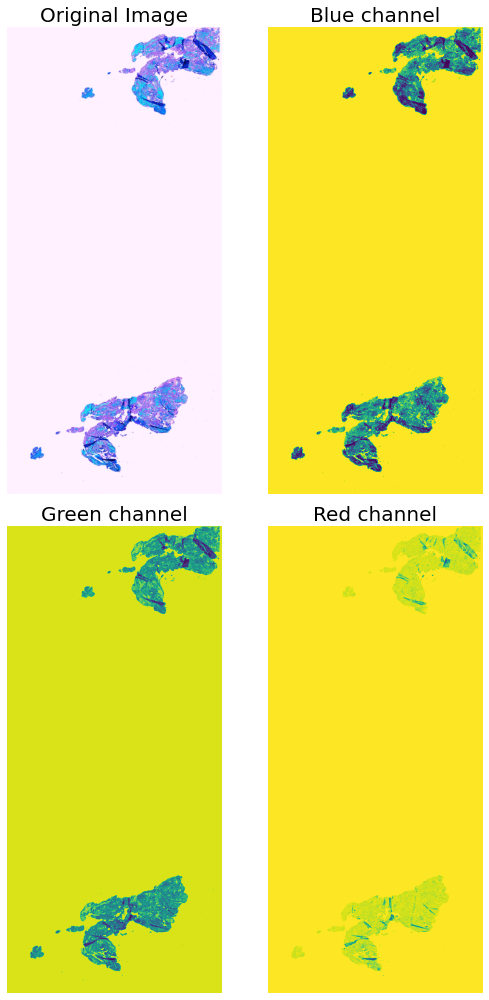

In [ ]:
# Select an image at random
PATH = '/content/drive/MyDrive/Data_sets/MAYO'
FOLDERS = ['CE','LAA']
folder =  np.random.choice(FOLDERS)
path = os.path.join(PATH,folder)
file = np.random.choice(os.listdir(path))
plt.figure(figsize=(10,20))
img = cv2.imread(os.path.join(path,file))
b,g,r = cv2.split(img)
imgs = [img,b,g,r]
title = ['Original Image', 'Blue channel', 'Green channel','Red channel']

plt.figure(figsize =(8,14))
for n,i in enumerate(imgs):
  plt.subplot(2,2,n+1)
  plt.imshow(i)
  plt.axis('off')
  plt.title(title[n], size = 20)
plt.tight_layout()
plt.show()

## Transforming to jpg

In [ ]:
#Delete files in a folder
import os, shutil
folder = '/content/drive/MyDrive/Data_sets/MAYOJPG/LAA'
for filename in os.listdir(folder):
    file_path = os.path.join(folder, filename)
    try:
        if os.path.isfile(file_path) or os.path.islink(file_path):
            os.unlink(file_path)
        elif os.path.isdir(file_path):
            shutil.rmtree(file_path)
    except Exception as e:
        print('Failed to delete %s. Reason: %s' % (file_path, e))

In [ ]:
PATH = '/content/drive/MyDrive/Data_sets/MAYO'
DESTINATION = '/content/drive/MyDrive/Data_sets/MAYOJPG'
folders = ['CE','LAA']
for folder in folders:
  files = os.listdir(os.path.join(PATH,folder))
  for file in files:
    impath = os.path.join(PATH,folder,file)
    imdest = os.path.join(DESTINATION,folder,file+'.png')
    img = cv2.imread(impath)
    img = Image.fromarray(img,'RGB')
    img.save(imdest)

## Non-NN image compression

### PCA

In [6]:
from sklearn.decomposition import PCA

In [ ]:
def openRandomImage():
  PATH = '/content/drive/MyDrive/Data_sets/MAYO'
  FOLDERS = ['CE','LAA']
  folder =  np.random.choice(FOLDERS)
  path = os.path.join(PATH,folder)
  file = np.random.choice(os.listdir(path))
  plt.figure(figsize=(10,20))
  img = cv2.imread(os.path.join(path,file))
  b,g,r = cv2.split(img)
  return (b,g,r)

* checking for maximum values

In [ ]:
b, g, r = openRandomImage()
np.max(b),np.max(g),np.max(r)

(255, 255, 255)

<Figure size 720x1440 with 0 Axes>

* Scaling channels

In [ ]:
rScaled = r/255
gScaled = g/255
bScaled = b/255

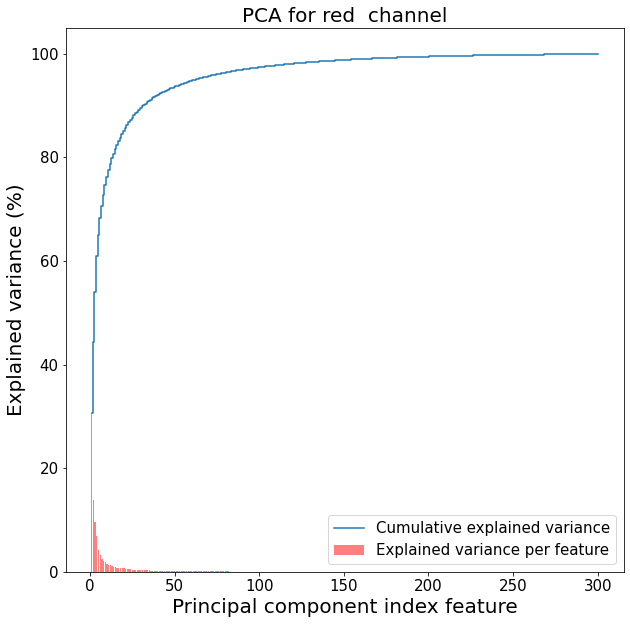

In [ ]:
numComp = 300 # In the CNN we want images of about 244 x 244
pcaModel = PCA(n_components=numComp)
pcaModel.fit(r)

explainVariance = pcaModel.explained_variance_ratio_ * 100
cummulativeExplainVariance = np.cumsum(explainVariance)

plt.figure(figsize=[10, 10])
plt.step(range(1, numComp+1), cummulativeExplainVariance, where='mid',label='Cumulative explained variance')
plt.bar(range(1, numComp+1), explainVariance, align='center',label='Explained variance per feature', color = 'red', alpha = 0.5)
plt.title("PCA for red  channel", size = 20)
plt.xlabel('Principal component index feature', size =20)
plt.ylabel('Explained variance (%)', size = 20)
plt.xticks(size= 15)
plt.yticks(size = 15)
plt.legend(fontsize = 15)
plt.show()

* we want to keep 95% of the information

In [ ]:
numFeatures = np.argmin(np.abs(cummulativeExplainVariance-98))
print(f'We need {numFeatures+1} features to keep 98% of the information')

We need 118 features to keep 98% of the information


In [ ]:
pcaR = PCA(n_components=numFeatures+1)
pcaR_trans = pcaR.fit_transform(rScaled)

pcaG = PCA(n_components=numFeatures+1)
pcaG_trans = pcaG.fit_transform(gScaled)

pcaB = PCA(n_components=numFeatures+1)
pcaB_trans = pcaB.fit_transform(bScaled)

print(f"% of information kept for red channel: {np.sum(pcaR.explained_variance_ratio_ )*100:.2f}")
print(f"% of information kept for green channel: {np.sum(pcaR.explained_variance_ratio_ )*100:.2f}")
print(f"% of information kept for blue channel: {np.sum(pcaR.explained_variance_ratio_ )*100:.2f}")

% of information kept for red channel: 97.99
% of information kept for green channel: 97.99
% of information kept for blue channel: 97.99


In [ ]:
pcaR_comp = pcaR.inverse_transform(pcaR_trans)
pcaG_comp = pcaG.inverse_transform(pcaG_trans)
pcaB_comp = pcaB.inverse_transform(pcaB_trans)

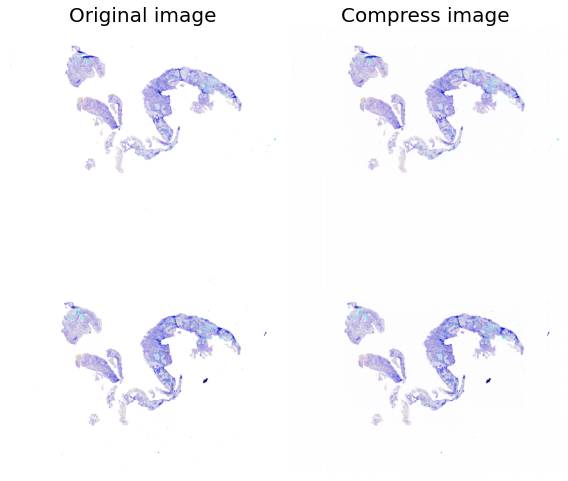

In [ ]:
imgOriginal = cv2.merge((b, g, r))
imgComp = cv2.merge((pcaB_comp, pcaG_comp, pcaR_comp))
images = [imgOriginal,imgComp]
title = ['Original image', 'Compress image']
plt.figure(figsize =(8,14))
for n,i in enumerate(images):
  plt.subplot(1,2,n+1)
  plt.imshow(i)
  plt.axis('off')
  plt.title(title[n], size = 20)
plt.tight_layout()
plt.show()

# Non-NN classification

## SVM

### Getting the data path

In [4]:
PATH = '/content/drive/MyDrive/Data_sets/MAYOPNG'
pathFiles = []
nameClasses = []
for root, _, files in os.walk(PATH):
  for file_ in files:
    pathFiles.append(os.path.join(root,file_))
    nameClasses.append(root.split('/')[-1])
fooDict = {'paths':pathFiles,'class':nameClasses}

df = pd.DataFrame.from_dict(fooDict)
df.head()

,paths,class
0,/content/drive/MyDrive/Data_sets/MAYOPNG/CE/00...,CE
1,/content/drive/MyDrive/Data_sets/MAYOPNG/CE/00...,CE
2,/content/drive/MyDrive/Data_sets/MAYOPNG/CE/02...,CE
3,/content/drive/MyDrive/Data_sets/MAYOPNG/CE/02...,CE
4,/content/drive/MyDrive/Data_sets/MAYOPNG/CE/03...,CE


### Getting the mean number of features for PCA



In [20]:
from sklearn.decomposition import PCA
import pickle

In [16]:
def pcaNumFearures(path:str,expVariance:int)->int:
  '''
  path: path to the image
  expVariance: Percent of explain variance from 1 to 100
  '''
  assert expVariance >= 1 and expVariance<=100, "expVariance has to be between 1 and 100"
  img = cv2.imread(path)
  channels = cv2.split(img)
  numComp = 120
  features = np.zeros((3,), dtype=int)
  for n,ch in enumerate(channels):
    pcaModel = PCA(n_components=numComp)
    pcaModel.fit(ch)
    explainVariance = pcaModel.explained_variance_ratio_ * 100
    cummulativeExplainVariance = np.cumsum(explainVariance)
    numFeatures = np.argmin(np.abs(cummulativeExplainVariance-expVariance))
    features[n] = numFeatures
  return int(np.mean(features))


In [17]:
tqdm.pandas()
df['featuresPca'] = df.progress_apply(lambda x: pcaNumFearures(x['paths'],95), axis = 1)

100%|██████████| 753/753 [14:44<00:00,  1.17s/it]


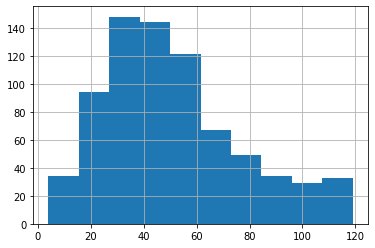

In [19]:
df['featuresPca'].hist()

In [21]:
PATH = '/content/drive/MyDrive/Data_sets/MAYOSTUFF'
with open(os.path.join(PATH,'dfPca.pickle'), 'wb') as handle:
    pickle.dump(df, handle)

In [28]:
PATH = '/content/drive/MyDrive/Data_sets/MAYOSTUFF'
with open(os.path.join(PATH,'dfPca.pickle'), 'rb') as handle:
    df = pickle.load(handle)

### Getting the common shapes

In [61]:
def getShape(path:str, comp:int)->tuple:
  img = cv2.imread(path)
  b,_,_ = cv2.split(img)
  FooShapes1 = list(b.shape)
  pcaModel = PCA(n_components=comp)
  pcaModel.fit(b)
  pcaB = pcaModel.fit_transform(b/255)
  FooShapes2 = list(pcaB.shape)
  shapes = [*FooShapes1,*FooShapes2]
  return shapes

In [62]:
df[['width', 'height','pcaWidth','pcaHeight']] = df.progress_apply(lambda x: getShape(x['paths'],x['featuresPca']), axis = 1, result_type = 'expand')

100%|██████████| 753/753 [01:49<00:00,  6.87it/s]


In [63]:
df.head()

,paths,class,featuresPca,width,height,pcaWidth,pcaHeight
0,/content/drive/MyDrive/Data_sets/MAYOPNG/CE/00...,CE,54,1024,572,1024,54
1,/content/drive/MyDrive/Data_sets/MAYOPNG/CE/00...,CE,19,1024,205,1024,19
2,/content/drive/MyDrive/Data_sets/MAYOPNG/CE/02...,CE,37,803,1024,803,37
3,/content/drive/MyDrive/Data_sets/MAYOPNG/CE/02...,CE,70,1024,992,1024,70
4,/content/drive/MyDrive/Data_sets/MAYOPNG/CE/03...,CE,37,1024,235,1024,37


In [64]:
df.describe()

,featuresPca,width,height,pcaWidth,pcaHeight
count,753.000000,753.000000,753.000000,753.000000,753.000000
mean,50.990704,949.686587,599.949535,949.686587,50.990704
std,26.363582,184.063862,266.333258,184.063862,26.363582
min,4.000000,137.000000,122.000000,137.000000,4.000000
25%,32.000000,1024.000000,391.000000,1024.000000,32.000000
50%,46.000000,1024.000000,532.000000,1024.000000,46.000000
75%,65.000000,1024.000000,815.000000,1024.000000,65.000000
max,119.000000,1024.000000,1024.000000,1024.000000,119.000000


In [65]:
PATH = '/content/drive/MyDrive/Data_sets/MAYOSTUFF'
with open(os.path.join(PATH,'dfPca.pickle'), 'wb') as handle:
    pickle.dump(df, handle)

### Images as features

In [81]:
def getfeatures(path:str,comp:int,width:int,height:int)->np.array:
  img = cv2.imread(path)
  channels = cv2.split(img)
  pcaimgs = []
  for ch in channels:
    pcaModel = PCA(n_components=comp)
    pcaModel.fit(ch)
    pcaimg = pcaModel.fit_transform(ch/255)
    pcaimgs.append(pcaimg)
  imgComp = cv2.merge(pcaimgs)
  imgF = cv2.resize(imgComp, (width,height), interpolation = cv2.INTER_AREA)
  b,g,r = cv2.split(imgF)
  b = b.ravel()
  g = g.ravel()
  r = r.ravel()
  features = np.concatenate ((b,g,r))
  return features


In [82]:
feats = np.array([getfeatures(row['paths'],row['featuresPca'],950,51) for n, row in tqdm(df.iterrows())])

753it [05:05,  2.46it/s]


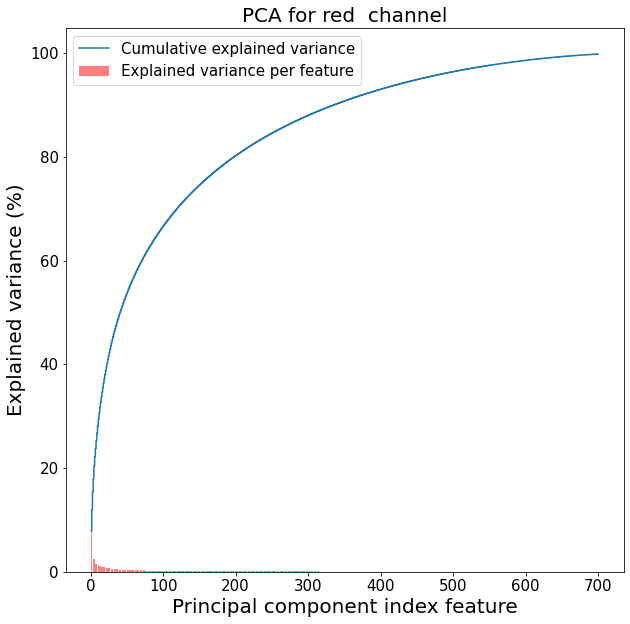

In [90]:
numComp = 700
pcaModel = PCA(n_components=numComp)
pcaModel.fit(feats)
explainVariance = pcaModel.explained_variance_ratio_ * 100
cummulativeExplainVariance = np.cumsum(explainVariance)

plt.figure(figsize=[10, 10])
plt.step(range(1, numComp+1), cummulativeExplainVariance, where='mid',label='Cumulative explained variance')
plt.bar(range(1, numComp+1), explainVariance, align='center',label='Explained variance per feature', color = 'red', alpha = 0.5)
plt.title("PCA for red  channel", size = 20)
plt.xlabel('Principal component index feature', size =20)
plt.ylabel('Explained variance (%)', size = 20)
plt.xticks(size= 15)
plt.yticks(size = 15)
plt.legend(fontsize = 15)
plt.show()

In [93]:
numFeatures = np.argmin(np.abs(cummulativeExplainVariance-98))
print(f'We need {numFeatures+1} features to keep 98% of the information')

We need 568 features to keep 98% of the information


* Feature transformation

In [94]:
numFeatures = 568
pcaModel = PCA(n_components=numFeatures+1)
pcaModel.fit(feats)
pcaFeat = pcaModel.fit_transform(feats)

In [96]:
feats.shape

(753, 145350)

In [95]:
pcaFeat.shape

(753, 569)

In [97]:
PATH = '/content/drive/MyDrive/Data_sets/MAYOSTUFF'
with open(os.path.join(PATH,'pcaFeat.pickle'), 'wb') as handle:
    pickle.dump(pcaFeat, handle)

* Y array

In [99]:
df['class'].unique()

array(['CE', 'LAA'], dtype=object)

In [100]:
Y = np.array([0 if row['class']=='CE' else 1 for n, row in df.iterrows()])

### SVM model

In [107]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold

In [102]:
X_train, X_test, y_train, y_test = train_test_split(pcaFeat, Y,stratify=Y, test_size=0.1)

In [106]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [109]:
kfold=KFold(n_splits=4, shuffle=True, random_state=0)

In [111]:
svc=SVC()
parameters = [ {'C':[1, 10, 100, 1000], 'kernel':['linear']},
               {'C':[1, 10, 100, 1000], 'kernel':['rbf'], 'gamma':[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]},
               {'C':[1, 10, 100, 1000], 'kernel':['poly'], 'degree': [2,3,4] ,'gamma':[0.01,0.02,0.03,0.04,0.05]} 
              ]
gridSearch = GridSearchCV(estimator = svc,  
                          param_grid = parameters,
                          scoring = 'accuracy',
                          cv = kfold,
                          n_jobs=-1,
                          verbose=10)
paramsGrid = gridSearch.fit(X_train, y_train)
print(paramsGrid.best_params_)
print(f'Best score: {paramsGrid.best_score_}')

Fitting 4 folds for each of 100 candidates, totalling 400 fits
{'C': 1000, 'degree': 3, 'gamma': 0.01, 'kernel': 'poly'}
Best score: 0.7282022276366168


* Results

In [121]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

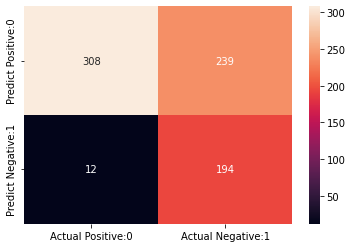

In [120]:
svc = SVC(**paramsGrid.best_params_)
svc.fit(X_train,y_train)
y_pred = svc.predict(pcaFeat)
cm = confusion_matrix(Y, y_pred)
cm_matrix = pd.DataFrame(data=cm, columns=['Actual Positive:1', 'Actual Negative:1'], 
                                 index=['Predict Positive:0', 'Predict Negative:1'])

sns.heatmap(cm_matrix, annot=True, fmt='d')

In [122]:
print(classification_report(Y, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.56      0.71       547
           1       0.45      0.94      0.61       206

    accuracy                           0.67       753
   macro avg       0.71      0.75      0.66       753
weighted avg       0.82      0.67      0.68       753



# Base CNN

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import PIL
PIL.PILLOW_VERSION = PIL.__version__
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from torchvision.utils import make_grid
from sklearn.metrics import confusion_matrix
from tqdm import trange
import time

In [ ]:
train_transform = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.RandomHorizontalFlip(p = 0.5),
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean = [0.485,0.456,0.406],std=[0.229,0.224,0.225])
])

In [ ]:
torch.manual_seed(42)
PATH = '/content/drive/MyDrive/Data_sets/MAYOPNG/'
shutil.rmtree(os.path.join(PATH,'.ipynb_checkpoints')) if '.ipynb_checkpoints' in os.listdir(PATH) else None
train_data = datasets.ImageFolder(PATH,transform = train_transform)
train_loader = DataLoader(train_data, batch_size = 10, shuffle = True)
class_names = train_data.classes# the class names are taken from the subfolder names

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
AlexNetmodel = models.alexnet(pretrained=True)

In [ ]:
AlexNetmodel

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

* There are 1000 features out. We need only 2 features out

In [ ]:
AlexNetmodel.classifier = nn.Sequential(nn.Linear(in_features=9216, out_features=4096, bias=True),
                            nn.ReLU(inplace=True),
                            nn.Dropout(p=0.5, inplace=False),
                            nn.Linear(in_features=4096, out_features=4096, bias=True),
                            nn.ReLU(inplace=True),
                            nn.Linear(in_features=4096, out_features=2000, bias=True),
                            nn.ReLU(inplace=True),
                            nn.Linear(in_features=2000, out_features=1000, bias=True),
                            nn.ReLU(inplace=True),
                            nn.Linear(in_features=1000, out_features=2, bias=True),
                            nn.LogSoftmax(dim = 1))

In [ ]:
AlexNetmodel

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Linear(in_features=9216, out_features=4096, bias=True)
    (1): ReLU(inplace=True)
    (2): Dro

In [ ]:
dev = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
AlexNetmodel.to(dev)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(AlexNetmodel.classifier.parameters(), lr = 0.001)


epochs = 1 # Only one epoch. CNN weights already trained and freeze
trainLosses = []
testLosses = []
trainCorrect = []
testCorrect = []

#Limit the number the batches
max_trn_batch = 800  # 10 images per batch --  8_000 images in total
max_tst_batch = 300


startTime = time.time()

with trange(epochs, unit="epoch") as pbar:
    for epoch in pbar:
        trn_correct = 0
        tst_correct = 0

        for b, (X_train, Y_train) in enumerate(train_loader):
            X_train, Y_train = X_train.to(device), Y_train.to(device)
            
            # if b == max_trn_batch:
            #     break
            b = b+1
            y_pred =AlexNetmodel(X_train)
            loss = criterion(y_pred,Y_train)
            predicted = torch.max(y_pred.data,1)[1]
            batch_corr = (predicted == Y_train).sum()
            trn_correct += batch_corr
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            accuracy = trn_correct.item()*100/(10*b)
            pbar.set_postfix(loss=loss.item(), acc=accuracy)
            
        trainLosses.append(loss)
        trainCorrect.append(trn_correct)

#        with torch.no_grad():
#            for b, (X_test, Y_test) in enumerate(test_loader):
#                # if b == max_tst_batch:
#                #     break
#                y_val = AlexNetmodel(X_test)
#                predicted = torch.max(y_val.data,1)[1]
#                tst_correct += (predicted == Y_test).sum()
#        loss = criterion(y_val, Y_test)
#        testLosses.append(loss)
#        testCorrect.append(tst_correct)
        
totalTime = time.time() - startTime
print(f'Duration: {totalTime/60} mins')
#torch.save(model.state_dict(),'./models/cat_dog_Alex.pt')

100%|██████████| 1/1 [01:23<00:00, 83.71s/epoch, acc=72, loss=0.221]

Duration: 1.3952745000521343 mins


In [ ]:
print(trainCorrect[-1].item()/(754/100))

72.54641909814323


* The accuracy of 72.5% is not surprising. CNN is learning to predict all as the most represented class in class. Because of this, the dataset needs to be balanced.